# import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# read data sets

In [2]:
directory = './MNIST_Dataset/'


## Train set

In [3]:
train_images_file = open(directory+'train-images.idx3-ubyte', 'rb')
train_images_file.seek(4)
num_of_train_images = int.from_bytes(train_images_file.read(4), 'big')
train_images_file.seek(16)

train_labels_file = open(directory+'train-labels.idx1-ubyte', 'rb')
train_labels_file.seek(8)

train_set = []
for n in range(num_of_train_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i, 0] = int.from_bytes(train_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(train_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    train_set.append((image, label))

## Test set

In [4]:
# Reading The Test Set
test_images_file = open(directory+'t10k-images.idx3-ubyte', 'rb')
test_images_file.seek(4)

test_labels_file = open(directory+'t10k-labels.idx1-ubyte', 'rb')
test_labels_file.seek(8)

num_of_test_images = int.from_bytes(test_images_file.read(4), 'big')
test_images_file.seek(16)

test_set = []
for n in range(num_of_test_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i] = int.from_bytes(test_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(test_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    test_set.append((image, label))

## Plot a sample 

In [5]:
def show_image(img):
    image = img.reshape((28, 28))
    plt.imshow(image, 'gray')

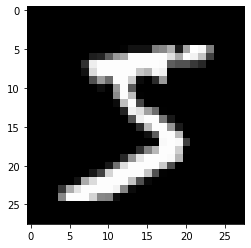

lable =  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [6]:
show_image(train_set[0][0])
plt.show()
print("lable = ",train_set[0][1])


# basic functions

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [8]:
def derivativeSigmoid(z):
    return  sigmoid(z) * (1 - sigmoid(z))

In [9]:
def make_sequential_network (layers):
    weights = list()
    biases = list()
    for i in range(len(layers)-1):
        weights.append(np.random.normal(0, .5, size=(layers[i+1], layers[i])))
        biases.append(np.random.normal(0, .5, size=(layers[i+1],1)))
    return weights,biases

In [10]:
def allocate_gradient_values (layers):
    g_weights = list()
    g_biases = list()
    for i in range(len(layers)-1):
        g_weights.append(np.zeros((layers[i+1], layers[i])))
        g_biases.append(np.zeros((layers[i+1],1)))
    return g_weights,g_biases
    

In [35]:
def calculate_network_values(flatten_input , current_weights,current_biases):
    network_output_layers = list()
    network_output_layers.append(flatten_input)
    z_layers= list()
    for (w,b) in zip(current_weights,current_biases):
        z = np.dot(w,network_output_layers[-1])+b
        z_layers.append(z)
        network_output_layers.append(sigmoid(z))
    return network_output_layers , z_layers

# make nueral network

## Variables 

In [39]:
units_of_layers = [784,16,16,10]
weights,biases = make_sequential_network(units_of_layers)

In [82]:
def train_model(learning_rate, number_of_epochs, batch_size, number_of_samples):
#     cost_by_epochs = np.zeros((10 ,number_of_epochs))
    for i in range(number_of_epochs):
        
        print("EPOCH {}".format(i))
        samples = train_set
        np.random.shuffle(samples)
        batches = [samples[x:x+batch_size] for x in range(0, number_of_samples, batch_size)]
        
        for batch in batches:
            grad_weights,grad_biases = allocate_gradient_values(units_of_layers)
            
            for image in batch:
                grad_a0 = np.zeros((784, 1))
                grad_a1 = np.zeros((16, 1))
                grad_a2 = np.zeros((16, 1))
                activations , z_values = calculate_network_values(image[0], weights, biases)
                label = image[1]
#                 cost = np.zeros((1,10))
#                 for n in range(10):
#                     cost[n] += (1.0/number_of_samples) *((activations[3][n] - label[n])[0] ** 2 )
#                 cost_by_epochs[i] = [x + y for (x, y) in zip(cost, cost_by_epochs[i])]
                
                #### layer 3
                
                for j in range(10):
                    b = 2 * (activations[3][j] - label[j]) * derivativeSigmoid(z_values[2][j])
                    grad_biases[2][j] +=b
                    for k in range(16):
                        grad_weights[2][j][k] +=b*activations[2][k]
                
                for k in range(16):
                    for j in range(10):
                        grad_a2[k] += 2 *(activations[3][j]-label[j]) * derivativeSigmoid(z_values[2][j]) *weights[2][j][k]

                ########layer 2
                for j in range(16):
                    b = grad_a2[j] * derivativeSigmoid(z_values[1][j])
                    grad_biases[1][j] +=b
                    for k in range(16):
                        grad_weights[1][j][k] +=b*activations[1][k]
                
                for k in range(16):
                    for j in range(16):
                        grad_a1[k] += 2 * grad_a2[j] * derivativeSigmoid(z_values[1][j]) * weights[1][j][k]
                ########layer 1
                for j in range(16):
                    b = grad_a1[j] * derivativeSigmoid(z_values[0][j])
                    grad_biases[0][j] +=b
                    for k in range(784):
                        grad_weights[0][j][k] +=b*activations[0][k]

            weights[0] -= learning_rate * (grad_weights[0] / batch_size)
            weights[1] -= learning_rate * (grad_weights[1] / batch_size)
            weights[2] -= learning_rate * (grad_weights[2] / batch_size)

            biases[0] -= learning_rate * (grad_biases[0] / batch_size)
            biases[1] -= learning_rate * (grad_biases[1] / batch_size)
            biases[2] -= learning_rate * (grad_biases[2] / batch_size)
                

In [83]:
train_model(1, 200, 10,100)

EPOCH 0
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20
EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40
EPOCH 41
EPOCH 42
EPOCH 43
EPOCH 44
EPOCH 45
EPOCH 46
EPOCH 47
EPOCH 48
EPOCH 49
EPOCH 50
EPOCH 51
EPOCH 52
EPOCH 53
EPOCH 54
EPOCH 55
EPOCH 56
EPOCH 57
EPOCH 58
EPOCH 59
EPOCH 60
EPOCH 61
EPOCH 62
EPOCH 63
EPOCH 64
EPOCH 65
EPOCH 66
EPOCH 67
EPOCH 68
EPOCH 69
EPOCH 70
EPOCH 71
EPOCH 72
EPOCH 73
EPOCH 74
EPOCH 75
EPOCH 76
EPOCH 77
EPOCH 78
EPOCH 79
EPOCH 80
EPOCH 81
EPOCH 82
EPOCH 83
EPOCH 84
EPOCH 85
EPOCH 86
EPOCH 87
EPOCH 88
EPOCH 89
EPOCH 90
EPOCH 91
EPOCH 92
EPOCH 93
EPOCH 94
EPOCH 95
EPOCH 96
EPOCH 97
EPOCH 98
EPOCH 99
EPOCH 100
EPOCH 101
EPOCH 102
EPOCH 103
EPOCH 104
EPOCH 105
EPOCH 106
EPOCH 107
EPOCH 108
EPOCH 109
EPOCH 110


In [84]:
def calculateAccuracy(weights,biases,size=100):
#     imgs = train_set[:size][0][0]
#     labels = train_set[:size][1][0]
    imgs = train_set[:size]
    labels = train_set[:size]
#     print("imsges size",np.shape(imgs))
#     output,_ = computeLayers(imgs, weights, biases)
#     print(output)
#     output = output[-1]
#     output = np.array(output)
#     labels = labels
#     print("type",type(labels))
#     print("shape",np.shape(labels))
    
    count = 0.0
    error =0
#     print("$$$$",np.shape(output))

    for i in range(size):
        img = imgs[i]
        image = img[0]
        labels = img[1]
        output,_ = calculate_network_values(image, weights, biases)
        output = output[-1]
        output = np.array(output)
#         print("^^^^^^^^^^^^^^^^^",np.shape(labels))
        labels = labels
        max_index = 0
        true_label = 0
        maximum = -1
        print (output)
        for j in range(10):
            if output[j] > maximum:
                maximum = output[j]
                max_index = j
            if labels[j] == 1:
                true_label = j
        
        if max_index == true_label:
            count += 1  
        else:
            show_image(image)
            plt.show()
            print("true : ",true_label)
            print("max_index",max_index)
            print ("hat:",output)
            print("----------------------------------")
            error += 1
#         else:
#             print(f"{true_label} {max_index}")
    print("err",error)
    return count/size
    

[[9.12576126e-04]
 [3.47063060e-03]
 [4.29877062e-02]
 [1.19533189e-03]
 [2.47853871e-03]
 [4.94071977e-04]
 [1.53513982e-02]
 [9.36654384e-01]
 [3.89103254e-03]
 [8.15285627e-03]]
[[1.01724892e-03]
 [5.45730094e-03]
 [2.06935812e-04]
 [2.58585643e-03]
 [1.47796303e-01]
 [6.76456397e-03]
 [6.89895485e-03]
 [4.35309316e-02]
 [1.22258044e-02]
 [8.83907431e-01]]
[[3.03435031e-05]
 [9.59724493e-01]
 [1.60639608e-03]
 [5.74367423e-03]
 [4.90093695e-03]
 [1.73014570e-03]
 [1.87620462e-03]
 [3.88729755e-03]
 [3.62933034e-02]
 [2.88351149e-02]]
[[8.98007297e-01]
 [5.59626676e-04]
 [1.27928880e-02]
 [1.03049780e-02]
 [4.06265504e-03]
 [1.23301614e-01]
 [4.24330927e-03]
 [1.12804384e-03]
 [8.94560792e-03]
 [1.85921978e-03]]
[[9.50813808e-01]
 [4.87129671e-04]
 [1.70616920e-02]
 [5.68090435e-03]
 [3.84144117e-03]
 [3.06301670e-02]
 [2.53774110e-02]
 [2.34740341e-03]
 [9.73627963e-04]
 [2.86300460e-03]]
[[2.28638088e-02]
 [1.51145134e-02]
 [9.49531880e-04]
 [2.61619744e-02]
 [3.73780069e-02]
 [8.5

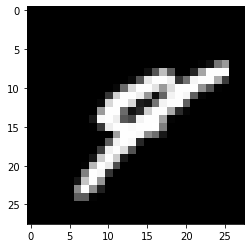

true :  4
max_index 1
hat: [[0.0005315 ]
 [0.35420429]
 [0.00289904]
 [0.00054051]
 [0.13736116]
 [0.05339525]
 [0.00123742]
 [0.00165291]
 [0.1942241 ]
 [0.00201402]]
----------------------------------
[[5.81151113e-04]
 [2.28916088e-02]
 [1.24942539e-02]
 [7.73993145e-03]
 [9.91756104e-04]
 [1.55078901e-02]
 [4.92176465e-02]
 [9.99011554e-03]
 [9.33476398e-01]
 [8.34371690e-02]]
[[1.61043147e-05]
 [9.71665157e-01]
 [1.41514818e-03]
 [3.31624977e-02]
 [7.26277920e-04]
 [1.39277079e-03]
 [1.18951142e-03]
 [8.47812691e-03]
 [1.92401574e-02]
 [2.74266361e-02]]
[[1.03889687e-03]
 [3.09531114e-02]
 [6.27908443e-03]
 [9.42738954e-01]
 [1.36142089e-04]
 [2.07245964e-02]
 [4.05678037e-04]
 [9.84982999e-03]
 [1.10126431e-02]
 [2.94755662e-02]]
[[0.00113979]
 [0.00487622]
 [0.00539456]
 [0.00658362]
 [0.00661359]
 [0.00636779]
 [0.00222715]
 [0.97481349]
 [0.00415843]
 [0.02615912]]
[[2.32297092e-02]
 [2.60407715e-03]
 [9.19683182e-01]
 [1.80459970e-02]
 [1.96172477e-03]
 [1.84795439e-04]
 [3.1

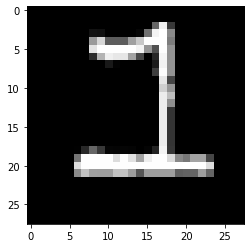

true :  1
max_index 2
hat: [[2.58269187e-02]
 [1.52951275e-03]
 [7.05687391e-01]
 [1.75908373e-01]
 [6.66365876e-04]
 [1.28380032e-03]
 [2.93202459e-02]
 [1.03444123e-02]
 [7.93268339e-05]
 [8.68578040e-05]]
----------------------------------
[[3.34828873e-05]
 [9.58720172e-01]
 [1.11094651e-03]
 [1.05922776e-02]
 [2.19915128e-03]
 [1.93160912e-03]
 [2.12794626e-03]
 [3.61491321e-03]
 [4.50002282e-02]
 [4.76159074e-02]]
[[3.85832390e-04]
 [9.40087094e-03]
 [4.53820090e-03]
 [4.26811445e-04]
 [8.97925343e-01]
 [9.25481979e-03]
 [5.59243453e-03]
 [1.80480386e-02]
 [6.04855323e-03]
 [5.05740602e-02]]
[[6.11947938e-04]
 [3.33591341e-02]
 [4.21839647e-03]
 [9.24064422e-01]
 [8.76585187e-05]
 [3.13589566e-02]
 [5.18923147e-04]
 [2.27202984e-02]
 [1.31705191e-02]
 [3.01114610e-02]]
[[8.35921430e-03]
 [3.76820992e-03]
 [9.72701296e-01]
 [5.79449638e-03]
 [1.21728771e-03]
 [1.16974297e-05]
 [1.39783459e-01]
 [2.31120936e-02]
 [2.59472925e-03]
 [3.94157428e-04]]
[[1.55764526e-03]
 [4.74274140e-0

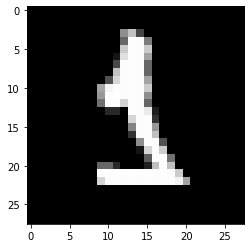

true :  1
max_index 8
hat: [[9.26912532e-04]
 [2.30642471e-02]
 [6.71444254e-04]
 [6.43036732e-03]
 [2.85619368e-04]
 [1.57391927e-01]
 [5.19538620e-02]
 [7.45686366e-03]
 [5.70314234e-01]
 [1.45655058e-02]]
----------------------------------
[[7.63643909e-04]
 [7.32390470e-03]
 [1.57173539e-04]
 [3.56834842e-03]
 [1.07419042e-01]
 [7.73691789e-03]
 [3.95613537e-03]
 [4.97187398e-02]
 [1.89800262e-02]
 [9.10585358e-01]]
[[9.77146618e-03]
 [5.86800442e-04]
 [5.11421342e-02]
 [7.02090483e-05]
 [2.65978513e-02]
 [2.46293725e-03]
 [9.65095966e-01]
 [6.84354556e-03]
 [7.86045306e-03]
 [6.16564847e-03]]
[[4.98896864e-03]
 [7.85387206e-02]
 [1.00126510e-02]
 [3.32753853e-03]
 [1.30256141e-02]
 [2.80297566e-01]
 [7.03115730e-03]
 [1.03383671e-03]
 [4.27335639e-01]
 [2.35895069e-04]]


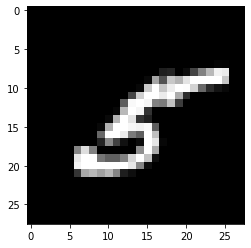

true :  5
max_index 8
hat: [[4.98896864e-03]
 [7.85387206e-02]
 [1.00126510e-02]
 [3.32753853e-03]
 [1.30256141e-02]
 [2.80297566e-01]
 [7.03115730e-03]
 [1.03383671e-03]
 [4.27335639e-01]
 [2.35895069e-04]]
----------------------------------
[[1.12800025e-04]
 [9.00490255e-02]
 [1.86790776e-02]
 [8.73643960e-01]
 [8.60967804e-04]
 [1.69391916e-03]
 [9.65257517e-05]
 [2.88333976e-02]
 [3.88956456e-03]
 [5.10045570e-02]]
[[9.24457426e-06]
 [9.67298730e-01]
 [3.13170312e-02]
 [3.07739147e-02]
 [3.94971280e-03]
 [2.32601846e-04]
 [7.04635963e-04]
 [9.74178503e-03]
 [1.62695931e-02]
 [1.24610120e-02]]
[[7.86713768e-02]
 [8.44986938e-04]
 [1.99348886e-04]
 [9.18302165e-03]
 [1.82902302e-02]
 [8.61777970e-01]
 [1.99653865e-02]
 [7.67290754e-03]
 [5.76453787e-02]
 [2.96448845e-02]]
[[5.02385126e-02]
 [3.93036918e-04]
 [1.65915850e-02]
 [9.42537090e-04]
 [2.21473811e-01]
 [9.69038648e-02]
 [3.19450341e-01]
 [3.32737977e-02]
 [7.99050889e-05]
 [3.87326218e-04]]


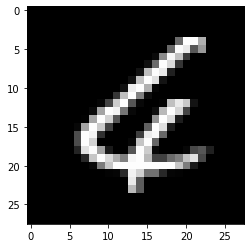

true :  4
max_index 6
hat: [[5.02385126e-02]
 [3.93036918e-04]
 [1.65915850e-02]
 [9.42537090e-04]
 [2.21473811e-01]
 [9.69038648e-02]
 [3.19450341e-01]
 [3.32737977e-02]
 [7.99050889e-05]
 [3.87326218e-04]]
----------------------------------
[[2.34211391e-03]
 [8.31442932e-01]
 [1.07102697e-02]
 [2.01934185e-02]
 [1.88931373e-04]
 [5.71118426e-03]
 [9.48396482e-03]
 [4.28479833e-04]
 [3.63371102e-02]
 [1.18354709e-03]]
[[0.00378173]
 [0.03322667]
 [0.00497473]
 [0.00219192]
 [0.0011317 ]
 [0.05945081]
 [0.01448102]
 [0.00295154]
 [0.9377407 ]
 [0.0203274 ]]
[[9.78932948e-02]
 [2.91307046e-03]
 [6.45543876e-03]
 [4.18724696e-04]
 [2.16259305e-03]
 [7.67840259e-02]
 [6.17031236e-01]
 [3.63267779e-04]
 [1.90758320e-02]
 [6.08541424e-04]]
[[5.45356688e-02]
 [1.47795420e-02]
 [2.76336725e-01]
 [3.93637078e-01]
 [3.49043183e-04]
 [1.31804172e-03]
 [7.61663034e-04]
 [4.09376524e-02]
 [4.10369261e-02]
 [1.38240625e-02]]


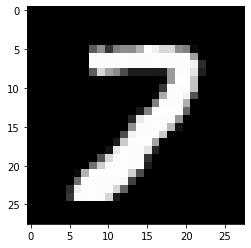

true :  7
max_index 3
hat: [[5.45356688e-02]
 [1.47795420e-02]
 [2.76336725e-01]
 [3.93637078e-01]
 [3.49043183e-04]
 [1.31804172e-03]
 [7.61663034e-04]
 [4.09376524e-02]
 [4.10369261e-02]
 [1.38240625e-02]]
----------------------------------
[[1.25084040e-02]
 [1.49605603e-02]
 [1.07358994e-02]
 [9.40867448e-01]
 [2.48515388e-04]
 [6.87333824e-02]
 [2.34621895e-03]
 [9.33659617e-03]
 [2.65220527e-03]
 [8.81343948e-03]]
[[5.57470083e-01]
 [5.69508248e-04]
 [7.50326065e-02]
 [7.96762490e-03]
 [7.92047972e-03]
 [5.53660188e-02]
 [1.45082674e-02]
 [3.59359549e-03]
 [4.47983732e-05]
 [1.63736076e-05]]
[[1.06014893e-02]
 [6.72303216e-02]
 [7.69364885e-03]
 [1.67429337e-02]
 [7.38294379e-03]
 [5.47672301e-01]
 [7.39148497e-03]
 [5.22441475e-04]
 [6.78505578e-02]
 [3.77310112e-05]]
[[2.09334180e-03]
 [8.14261441e-04]
 [8.81149523e-03]
 [1.96843150e-04]
 [1.25375638e-02]
 [1.11431361e-02]
 [9.48775097e-01]
 [1.20038001e-02]
 [2.10863716e-02]
 [1.02655817e-02]]
[[7.02123732e-03]
 [5.67402409e-0

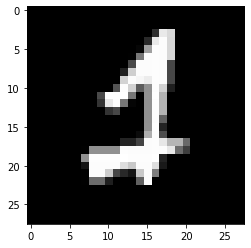

true :  1
max_index 6
hat: [[8.75261902e-02]
 [6.60774907e-04]
 [7.00818241e-02]
 [2.61849989e-03]
 [3.48128331e-03]
 [1.46963540e-03]
 [2.97209458e-01]
 [4.64709304e-02]
 [2.65147953e-04]
 [3.46891212e-03]]
----------------------------------
[[3.79114683e-03]
 [1.37313282e-02]
 [5.47093378e-03]
 [9.20373077e-01]
 [1.06795791e-04]
 [9.03970880e-02]
 [3.46154938e-03]
 [2.93403966e-02]
 [4.85236180e-03]
 [1.28867917e-02]]
[[1.37190334e-05]
 [9.72873242e-01]
 [1.50274901e-03]
 [5.02244800e-02]
 [6.55174543e-04]
 [1.52334825e-03]
 [1.20092850e-03]
 [8.46391632e-03]
 [1.85690698e-02]
 [2.83034116e-02]]
[[0.00716456]
 [0.02465464]
 [0.00725758]
 [0.00118062]
 [0.00195758]
 [0.05061929]
 [0.01643922]
 [0.00269079]
 [0.9278558 ]
 [0.01819147]]
[[3.32053001e-02]
 [1.68152699e-02]
 [8.66934219e-02]
 [8.29921041e-01]
 [1.05580014e-04]
 [1.86579645e-02]
 [4.64837773e-04]
 [1.40578209e-02]
 [1.42886115e-02]
 [2.31993774e-03]]
[[4.46650390e-05]
 [9.55310859e-01]
 [1.37411244e-03]
 [1.83826189e-02]
 

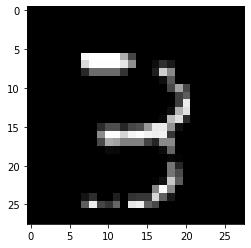

true :  3
max_index 4
hat: [[0.00099297]
 [0.00539197]
 [0.03827481]
 [0.00936911]
 [0.76909659]
 [0.00253494]
 [0.00223224]
 [0.07307464]
 [0.002565  ]
 [0.04999462]]
----------------------------------
[[7.72807066e-01]
 [1.67626852e-03]
 [6.24890770e-02]
 [8.47277752e-03]
 [9.87540035e-04]
 [2.01781651e-02]
 [3.51418971e-02]
 [3.33020813e-04]
 [1.14407886e-02]
 [5.22920901e-04]]


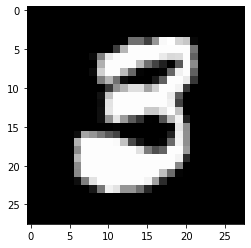

true :  3
max_index 0
hat: [[7.72807066e-01]
 [1.67626852e-03]
 [6.24890770e-02]
 [8.47277752e-03]
 [9.87540035e-04]
 [2.01781651e-02]
 [3.51418971e-02]
 [3.33020813e-04]
 [1.14407886e-02]
 [5.22920901e-04]]
----------------------------------
[[5.08751568e-05]
 [9.51475173e-01]
 [1.44338131e-03]
 [1.44379432e-02]
 [7.37604612e-04]
 [1.57880222e-03]
 [1.94486719e-03]
 [4.12239112e-03]
 [4.64491445e-02]
 [2.85754720e-02]]
[[6.37362484e-05]
 [1.35277366e-02]
 [8.56161642e-04]
 [6.99093780e-04]
 [5.52587978e-02]
 [2.90674029e-03]
 [3.96256415e-02]
 [6.55313802e-02]
 [6.85080989e-02]
 [5.11399620e-01]]
[[4.24198743e-02]
 [7.10904847e-03]
 [1.49286773e-02]
 [8.39248312e-01]
 [7.85524403e-05]
 [4.23210411e-02]
 [1.62472400e-02]
 [2.39260866e-02]
 [5.10975156e-04]
 [3.48980882e-03]]
[[1.10759564e-02]
 [2.94871803e-03]
 [2.17958634e-04]
 [1.49532764e-01]
 [1.52425823e-03]
 [8.41668695e-01]
 [4.05363715e-03]
 [2.18012439e-03]
 [5.71294502e-02]
 [1.02874242e-02]]
[[5.25799010e-06]
 [9.45656402e-0

0.91

In [85]:
calculateAccuracy(weights,biases)